In [1]:
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

from tensorflow.keras import layers

import warnings

warnings.filterwarnings("ignore")

2023-12-05 11:40:48.878620: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-05 11:40:48.929407: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 11:40:48.929440: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 11:40:48.930657: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 11:40:48.938585: I tensorflow/core/platform/cpu_feature_guar

In [2]:
from dataclasses import dataclass

@dataclass
class Parameters:
    learning_rate: float = 0.001
    batch_size: int = 32
    data_dir = Path('data')
    train_dir = data_dir / 'flower_photos'
    verbose = 1
    epochs = 20
    img_size = 224
    img_shape = (img_size, img_size, 3)
    class_names = None
    seed = 42
    

In [3]:
data_dir = Path('data')
train_dir = data_dir / 'flower_photos'

In [4]:
# Your existing code
batch_size = 32
img_height = 150
img_width = 150

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size)

class_names = train_ds.class_names

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


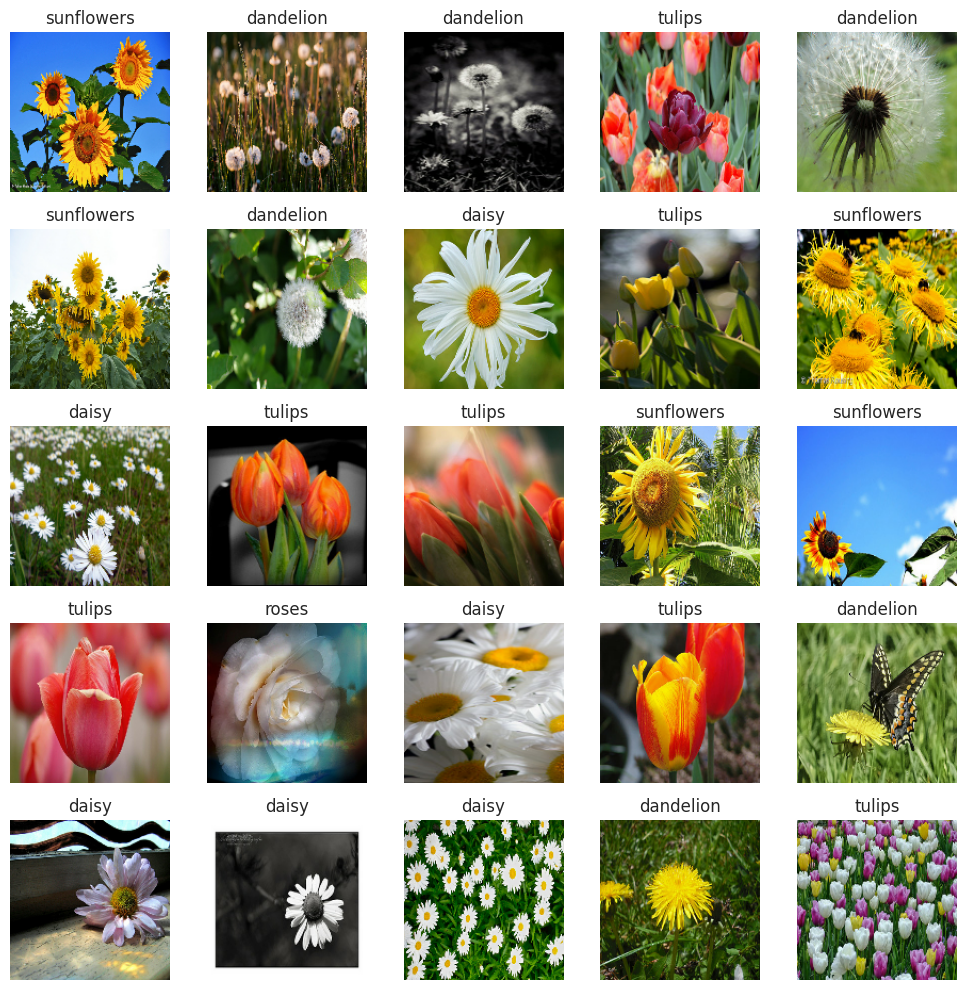

In [5]:
def plot_images(dataset, class_names, num_images=25):
    # Get a batch of images and labels from the dataset
    image_batch, label_batch = next(iter(dataset))

    plt.figure(figsize=(10, 10))
    sns.set_style("whitegrid")
    for i in range(num_images):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        label = class_names[label_batch[i]]
        plt.title(label)
        plt.axis("off")
    plt.tight_layout()

plot_images(train_ds, class_names=train_ds.class_names)

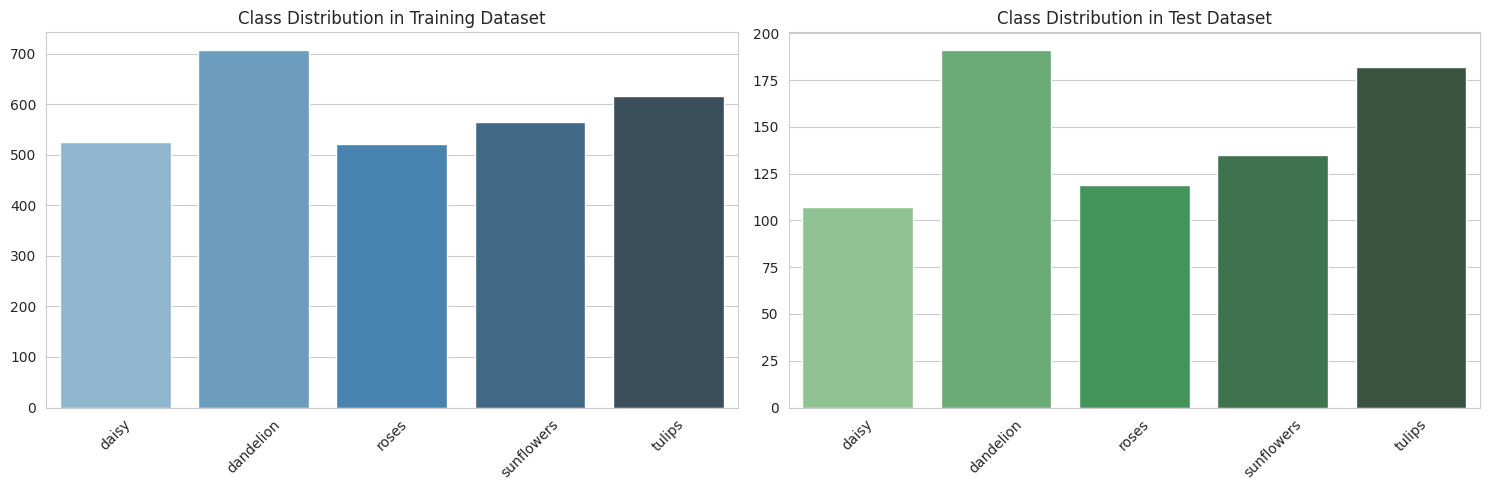

In [6]:
def plot_class_distribution(train_ds, test_ds, class_names):
    # Get the class distributions in the datasets
    train_class_distribution = Counter([class_names[label] for images, labels in train_ds for label in labels])
    test_class_distribution = Counter([class_names[label] for images, labels in test_ds for label in labels])

    # Sort the keys and values of the class distributions
    train_keys, train_values = zip(*sorted(train_class_distribution.items()))
    test_keys, test_values = zip(*sorted(test_class_distribution.items()))

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot the class distribution in the training dataset
    sns.barplot(x=list(train_keys), y=list(train_values), ax=axs[0], palette="Blues_d")
    axs[0].set_title('Class Distribution in Training Dataset')
    axs[0].tick_params(axis='x', rotation=45)

    # Plot the class distribution in the test dataset
    sns.barplot(x=list(test_keys), y=list(test_values), ax=axs[1], palette="Greens_d")
    axs[1].set_title('Class Distribution in Test Dataset')
    axs[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

plot_class_distribution(train_ds, val_ds, class_names)

In [7]:
preprocessing_layer = tf.keras.Sequential([
    layers.Rescaling(1./255),
])
augmentation_layer = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical", seed=42),
    layers.RandomRotation(0.2, seed=42),
    layers.RandomZoom(0.3, seed=42),
    layers.RandomTranslation(0.2, 0.2, seed=42),
    ])

In [8]:
def create_model():
    tf.keras.backend.clear_session()
    model = tf.keras.Sequential([
    tf.keras.Input(shape=(img_height, img_width, 3)),
    preprocessing_layer,
    augmentation_layer,
    layers.Conv2D(32, 5, padding='same', activation='relu'),
    layers.Conv2D(32, 5, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(512, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(512, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(len(class_names))
    ])
    return model

In [9]:
model = create_model()
model.summary(expand_nested=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 150, 150, 3)       0         
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| rescaling (Rescaling)      (None, 150, 150, 3)       0        |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| random_flip (RandomFlip)   (None, 150, 150, 3)       0        |
|                                                               |
| random_rotation (RandomRo  (None, 150, 150, 3)       0        |
| tation)                                                       |
|                                                               |
| random_zoom (RandomZoom)   (None, 150, 150, 3)       0        |
|                                                     

In [10]:
# define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#define loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#compile model
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-8, mode='min')
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('checkpoints/model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
callbacks = [reduce_lr, model_checkpoint]

In [11]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
#fit model
epochs=100
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epochs, 
    callbacks=callbacks,
    )


In [ ]:
#best baseline model

# def create_model():
#     model = tf.keras.Sequential([
#     tf.keras.Input(shape=(img_height, img_width, 3)),
#     preprocessing_layer,
#     augmentation_layer,
#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.Dropout(0.2),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(),
#     layers.Conv2D(128, 3, padding='same', activation='relu'),
#     layers.Conv2D(128, 3, padding='same', activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(),
#     layers.Conv2D(256, 3, padding='same', activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(),
#     layers.Conv2D(512, 3, padding='same', activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(),
#     layers.Conv2D(512, 3, padding='same', activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(),
#     layers.GlobalAveragePooling2D(),
#     layers.Dense(128, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(0.2),
#     layers.Dense(len(class_names))
#     ])
#     return model